In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

from Methods import select_points, add_boundary_points, morph_triangle, morph_images

In [5]:
# helper functions for ADNet landmark detection
import sys
sys.path.append('./')
# from external.ADNet.lib.backbone import stackedHGNetV1
from external.ADNet.lib.backbone import stackedHGNetV1
from external.ADNet.conf.alignment import Alignment
import torch
import os
import cv2
import matplotlib.pyplot as plt

# from the landmarks output by ADNet (B x N_points x 2), in the range of (-1, 1), convert to coordinates in the image  
def get_actual_coordinates(h, w, landmarks):
    x_pixel = ((landmarks[:, :, 0] + 1) / 2) * w
    y_pixel = ((landmarks[:, :, 1] + 1) / 2) * h
    return torch.stack((x_pixel, y_pixel), dim=2).squeeze(0).cpu().numpy()

# function to initalize ADNet
def initialize_net(model_path, device=torch.device("cuda")):
    config = Alignment()

    net = stackedHGNetV1.StackedHGNetV1(classes_num=config.classes_num, \
                                        edge_info=config.edge_info, \
                                        nstack=config.nstack, \
                                        add_coord=config.add_coord, \
                                        pool_type=config.pool_type, \
                                        use_multiview=config.use_multiview)

    checkpoint = torch.load(model_path)
    net.load_state_dict(checkpoint["net"])

    # send to gpu, set to evaluation mode
    net = net.float().to(device)
    net.eval()
    return net

# pass the image throguh ADNet to get landmarks in image coordinates
def get_landmarks_ADNet(img, net, device=torch.device("cuda")):
    old_h, old_w = img.shape[:2]
    # preprocess image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = img.astype('float32') / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(device)

    # get landmarks
    with torch.no_grad():
        _, _, landmarks = net(img)
        landmarks = get_actual_coordinates(old_h, old_w, landmarks)

    return landmarks

ModuleNotFoundError: No module named 'wandb'

In [2]:
# Load and resize images
img1 = cv2.imread('face_img.jpg', cv2.IMREAD_COLOR)
img2 = cv2.imread('lion_img.jpg', cv2.IMREAD_COLOR)
h, w = img1.shape[:2]
img2 = cv2.resize(img2, (w, h))  # Make sure they are same size!

Get points with ADNet

In [5]:
# initialize ADNet from a pretrained checkpoint
# only need to run it once
# device to use, recommand gpu
device = torch.device("cuda")
# path to pretrained checkpoint, downloaded from the link in ADNet repo
model_path = "C:/Users/weixuan2/Documents/data/ADNet_workdir/model/train.pkl"
net = initialize_net(model_path, device)

In [14]:
points1 = get_landmarks_ADNet(img1, net, device)
points2 = get_landmarks_ADNet(img2, net, device)


In [15]:
# Add boundary points
boundary = add_boundary_points(img1.shape)
points1 = np.vstack([points1, boundary])
points2 = np.vstack([points2, boundary])

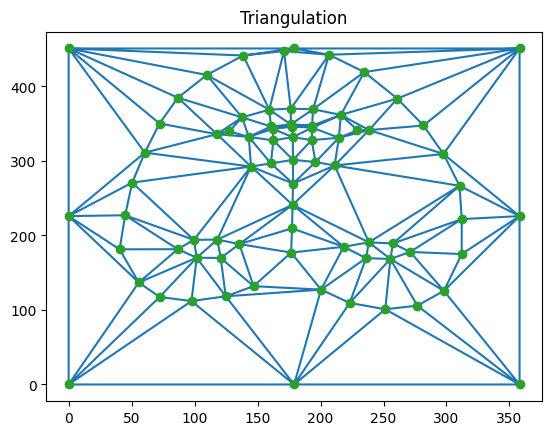

In [16]:
# Triangulate based on average shape
average_points = (points1 + points2) / 2
tri = Delaunay(average_points)

# Plot the triangulation
plt.triplot(average_points[:,0], average_points[:,1], tri.simplices)
plt.plot(average_points[:,0], average_points[:,1], 'o')
plt.title("Triangulation")
plt.show()

In [17]:
alpha = 0.5  # Half woman, half lion
morphed_img = np.zeros_like(img1, dtype=np.float32)


In [19]:
for tri_indices in tri.simplices:
    # Get vertices of current triangle
    x1 = points1[tri_indices]
    x2 = points2[tri_indices]
    x = average_points[tri_indices]  # Intermediate points

    # Compute affine transforms
    warp_mat1 = cv2.getAffineTransform(np.float32(x1), np.float32(x))
    warp_mat2 = cv2.getAffineTransform(np.float32(x2), np.float32(x))

    # Warp each triangle separately
    img1_warped = cv2.warpAffine(img1, warp_mat1, (w, h))
    img2_warped = cv2.warpAffine(img2, warp_mat2, (w, h))

    # Create mask for the triangle
    mask = np.zeros((h, w), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(x), 1.0, 16, 0)

    # Add to morphed image
    morphed_img += mask[:, :, np.newaxis] * ((1 - alpha) * img1_warped + alpha * img2_warped)


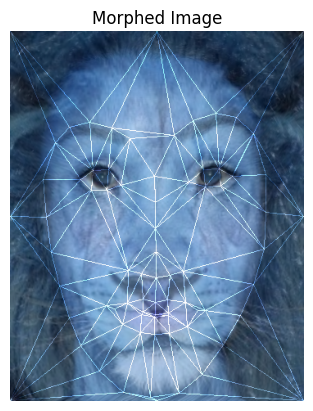

In [20]:
morphed_img = np.clip(morphed_img, 0, 255).astype(np.uint8)
plt.imshow(morphed_img, cmap='gray')
plt.title('Morphed Image')
plt.axis('off')
plt.show()

In [22]:
# Set up Video Writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter('morph_loop.mp4', fourcc, 15.0, (w, h), isColor=True)  # 15 fps, color video

# Create morph frames
num_frames = 100  # Forward frames
frames = []

# Generate forward morph
for i, alpha in enumerate(np.linspace(0, 1, num_frames)):
    print(f"Generating forward frame {i+1}/{num_frames}...")
    frame = morph_images(img1, img2, points1, points2, tri, alpha)
    frames.append(frame)

# Now frames[] contains Woman → Lion morph

# Write forward frames
for frame in frames:
    video_out.write(frame)

# Write backward frames (skip last frame to avoid repeated frame)
for frame in frames[-2::-1]:  # Start second to last frame, reverse
    video_out.write(frame)

video_out.release()
print("video saved as 'morph_loop.mp4'")


Generating forward frame 1/100...
Generating forward frame 2/100...
Generating forward frame 3/100...
Generating forward frame 4/100...
Generating forward frame 5/100...
Generating forward frame 6/100...
Generating forward frame 7/100...
Generating forward frame 8/100...
Generating forward frame 9/100...
Generating forward frame 10/100...
Generating forward frame 11/100...
Generating forward frame 12/100...
Generating forward frame 13/100...
Generating forward frame 14/100...
Generating forward frame 15/100...
Generating forward frame 16/100...
Generating forward frame 17/100...
Generating forward frame 18/100...
Generating forward frame 19/100...
Generating forward frame 20/100...
Generating forward frame 21/100...
Generating forward frame 22/100...
Generating forward frame 23/100...
Generating forward frame 24/100...
Generating forward frame 25/100...
Generating forward frame 26/100...
Generating forward frame 27/100...
Generating forward frame 28/100...
Generating forward frame 29/1

In [76]:
import cv2

cap = cv2.VideoCapture('morph_loop.mp4')

if not cap.isOpened():
    print("Error opening video file")

print("Playing video... Press Enter in the terminal to exit.")

while True:
    ret, frame = cap.read()

    if not ret:
        # If video ended, restart from beginning
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        continue

    cv2.imshow('Morph Video Preview', frame)

    # Check for keypress every 30ms
    if cv2.waitKey(70) == 13:  # 13 is Enter key
        break

cap.release()
cv2.destroyAllWindows()


Playing video... Press Enter in the terminal to exit.


In [2]:
#evaluating the accuracy of the interpolation

In [63]:
import sys
print(sys.executable)
#run this on python 3.12 please, 3.13 is incompatible with mediapipe and dlib doesn't work without cmake and vs c++ tools

In [76]:
import os
folder_path = './image_set'
image_names = os.listdir(folder_path)
loaded_images = [ cv2.resize((cv2.cvtColor(cv2.imread(folder_path + '/' + name),cv2.COLOR_BGR2RGB)), (128,128)) for name in image_names]

In [77]:
#the images above are strictly facial images, front facing so it's safe to use a facial mask for them
import mediapipe as mp

face_mesh_tools = mp.solutions.face_mesh
face_mesh = face_mesh_tools.FaceMesh(static_image_mode=True,max_num_faces=1,refine_landmarks=True,min_detection_confidence=0.5)

important_landmarks = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323,361,288, 397, 365, 379, 378, 400, 152, 148, 176, 136, 172,58, 132, 234, 127, 162, 21, 54, 103, 67, 109, 33, 133, 159, 145, 160, 144, 153, 154, 155,362, 263, 386, 374, 387, 373, 380, 381, 382,1, 2, 98, 327, 94, 331, 168, 197, 195, 5, 4,61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308, 78, 95, 88, 178]
facial_points = []
no_face = []
count_for_removal = 0 #this is used to remove 

for l_image in loaded_images:
    landmarks = face_mesh.process(l_image)
    width,height,_ = l_image.shape

    if landmarks.multi_face_landmarks: #if any face at all is detected, we select the first one
        facial_landmarks = landmarks.multi_face_landmarks[0] #they are spit out as a normalized value so we have to reintroduce them
        important_points_per_image = []
        for il in important_landmarks:
            x,y =  int(facial_landmarks.landmark[il].x * width), int(facial_landmarks.landmark[il].y * height)
            important_points_per_image.append((x,y))
        facial_points.append(important_points_per_image)
    else:
        no_face.append(count_for_removal)
    count_for_removal += 1
#We just got the landmarks and points needed to use the image morphing above

In [78]:
for entry in no_face:
    loaded_images.pop(entry)
    no_face.remove(entry)

In [79]:
print(len(loaded_images))

15


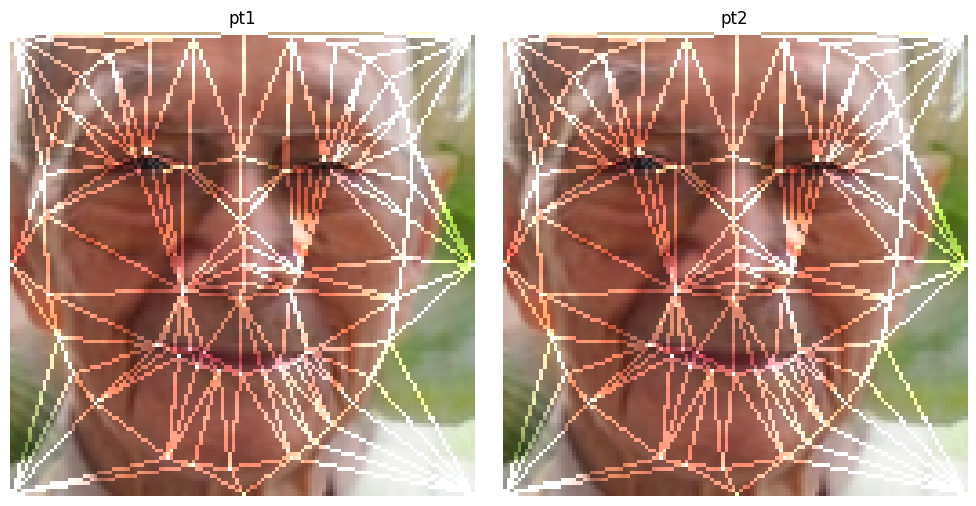

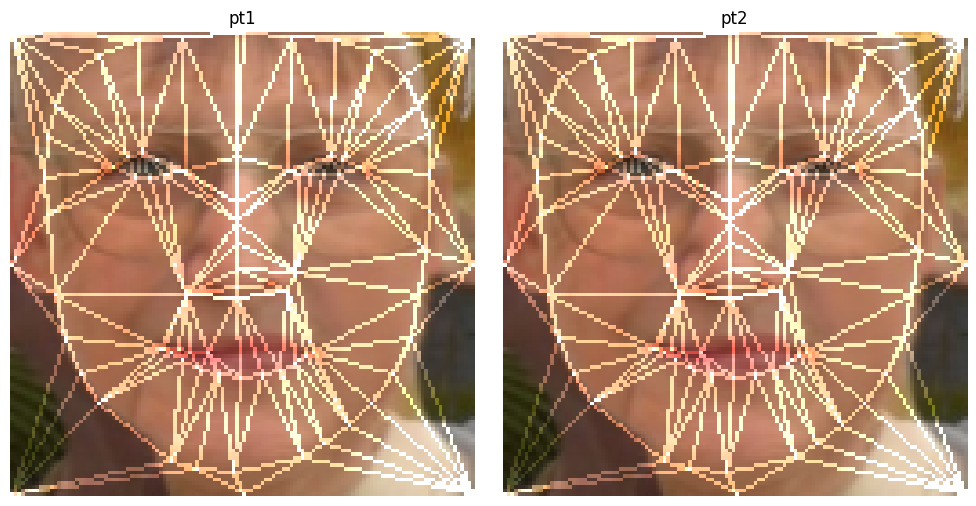

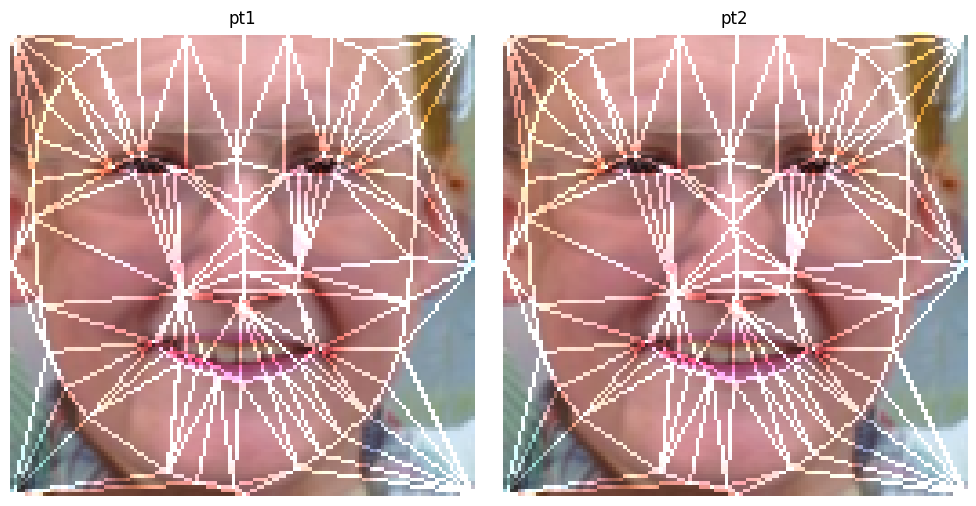

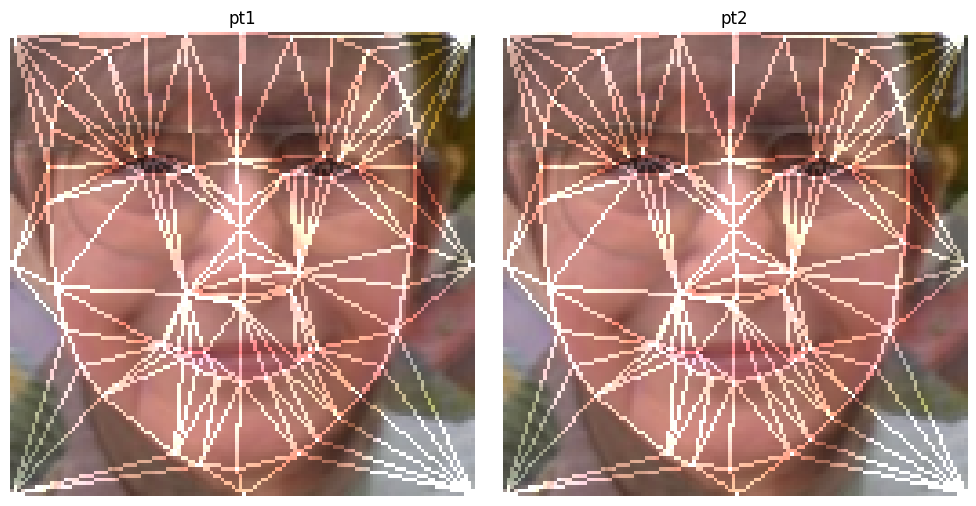

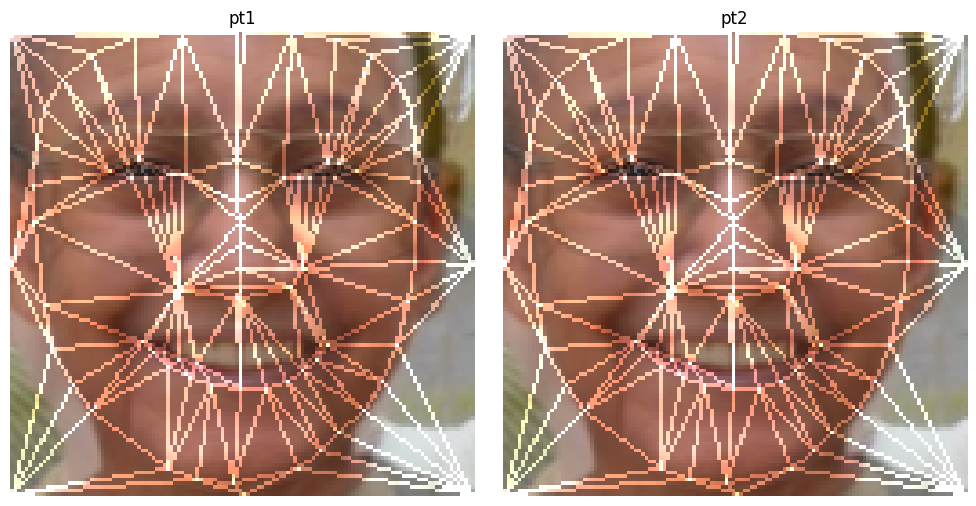

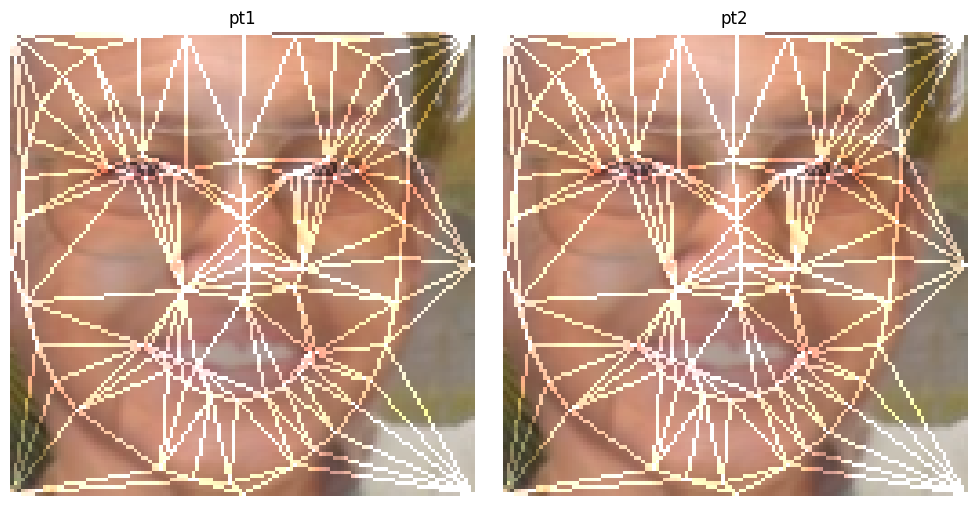

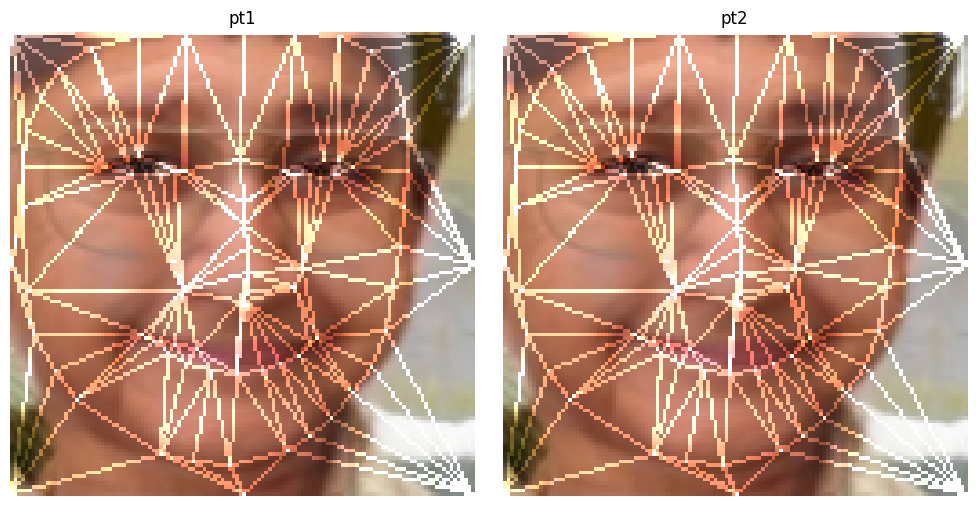

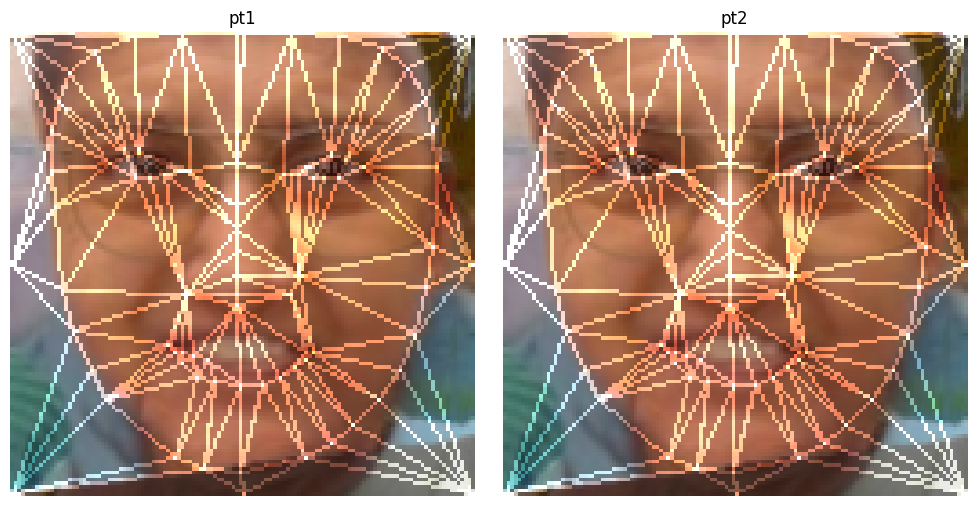

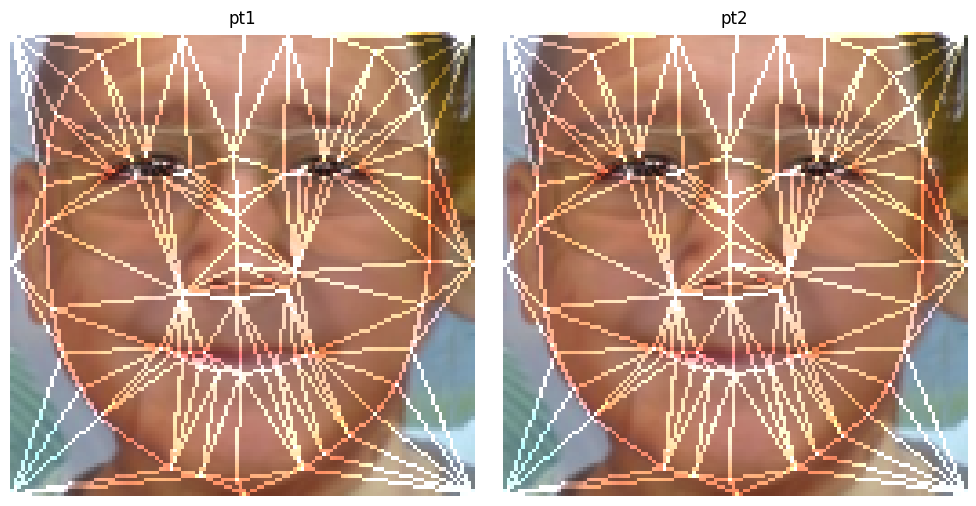

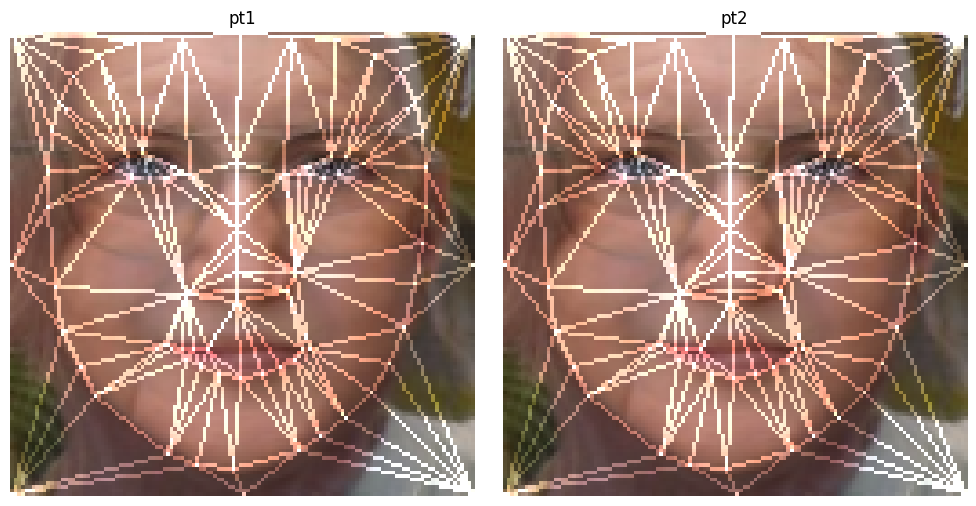

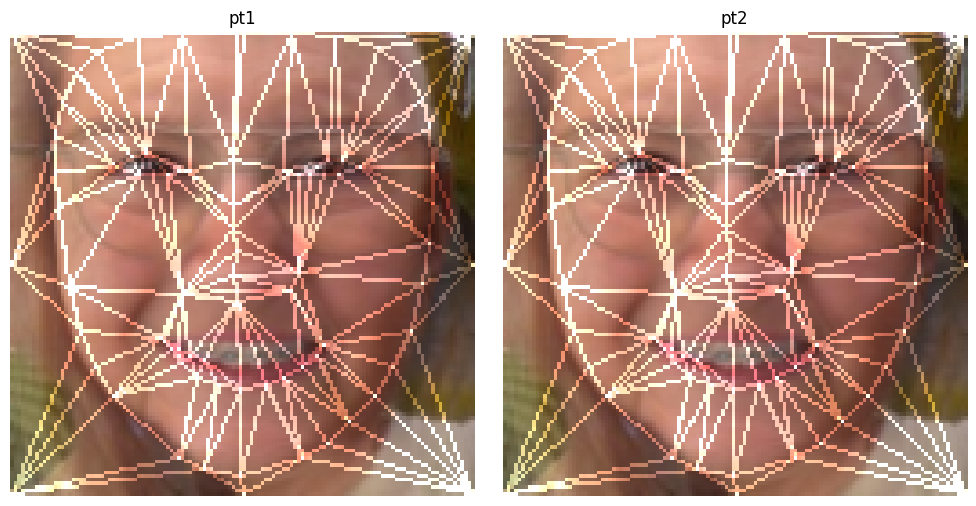

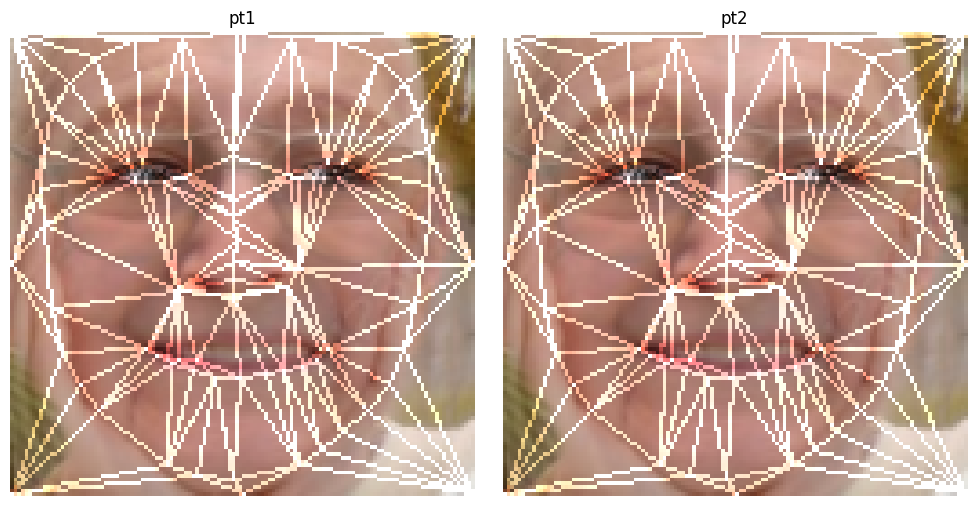

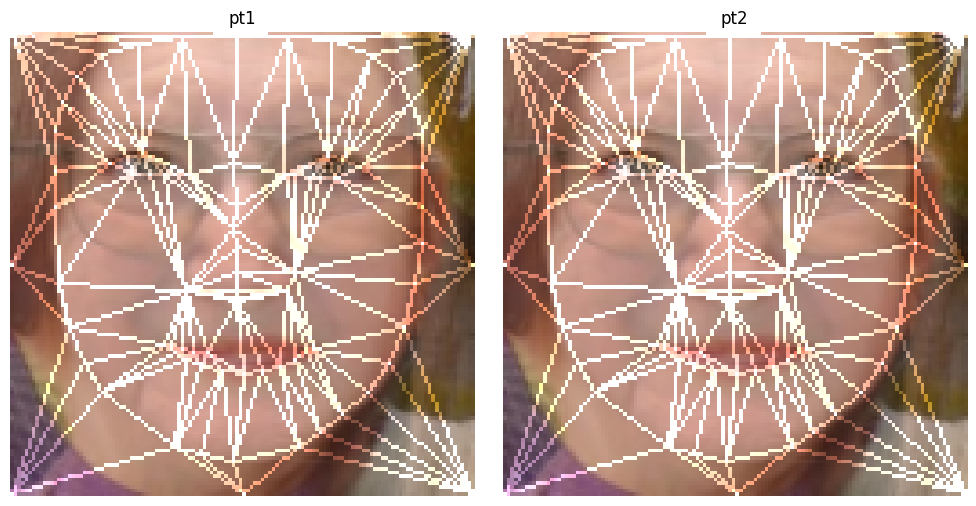

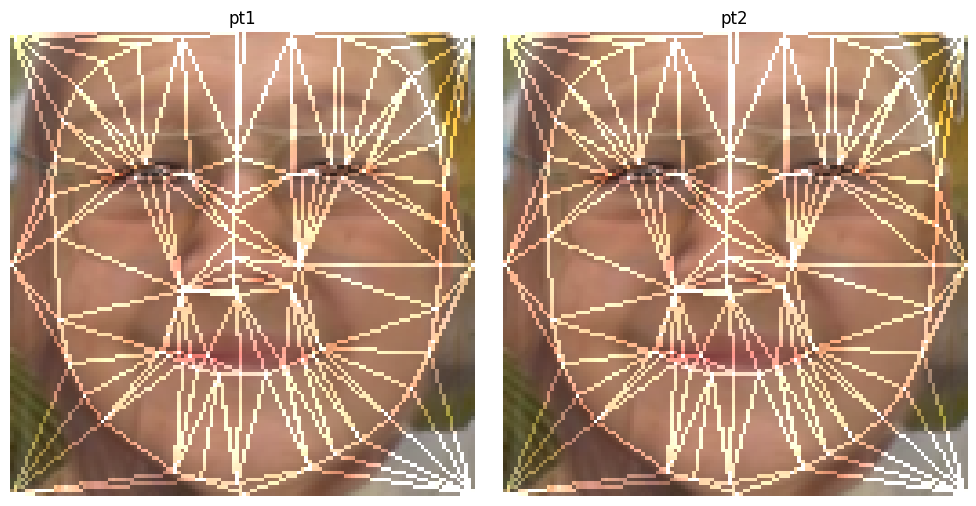

In [80]:
error = 0
first_image = loaded_images[0]
first_points1 = facial_points[0]
boundary_points = add_boundary_points(first_image.shape)
first_points = np.vstack([first_points1,boundary_points])

for i in range(1,len(loaded_images)):
    curr_image = loaded_images[i]
    curr_points = np.vstack([facial_points[i],boundary_points])
    avg_points = (first_points + curr_points) / 2
    triangular = Delaunay(avg_points)
    
    pt1 = morph_images(first_image, curr_image, first_points, curr_points, triangular, 0.5)
    pt2 = morph_images(curr_image, first_image, curr_points, first_points, triangular, 0.5)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(pt1)
    plt.title("pt1")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(pt2)
    plt.title("pt2")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    error += np.linalg.norm(pt1 - pt2)

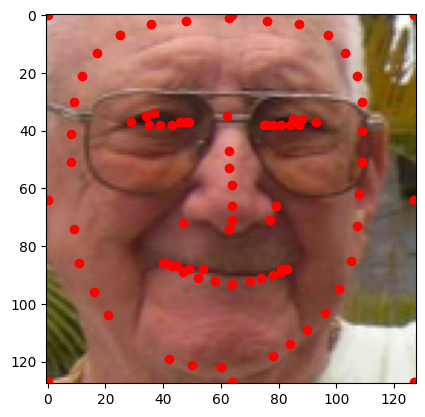

In [82]:
#Here we're showing that mediapipe is working well, detecting all the landmarks within each image provided
plt.imshow(first_image)
for point_x,point_y in first_points:
    plt.plot(point_x,point_y,'ro')
plt.show()

In [83]:
print(error) # no error at all from the interpolation method

0.0
